# Age Estimation task

## Imports

In [277]:
import numpy as np
import pandas as pd

import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import librosa
# %matplotlib widget

## Constants

In [278]:
FILE_DEVELOPMENT = "Dataset/development.csv"
FILE_EVALUATION = "Dataset/evaluation.csv"
AUDIOS_DEVELOPMENT = "Dataset/audios_development/"
AUDIOS_EVALUATION = "Dataset/audios_evaluation/"

## File reading

In [279]:
dev_original_df = pd.read_csv(FILE_DEVELOPMENT, header=0, index_col=0)
eval_original_df = pd.read_csv(FILE_EVALUATION, header=0, index_col=0)

## Data Exploration

In [ ]:
# display(dev_original_df.head())

display(f"Total number of nan in development: {dev_original_df.isna().sum().sum()}")
display(f"Total number of nan in evaluation: {eval_original_df.isna().sum().sum()}")

desc_dev_df = dev_original_df.describe()
desc_eval_df = eval_original_df.describe()

sampling_rate = dev_original_df['sampling_rate'].iloc[0]

# display(desc_dev_df.loc['std', 'sampling_rate'])
# display(desc_eval_df.loc['std', 'sampling_rate'])

dev_df = dev_original_df.drop('sampling_rate', axis=1)
eval_df = eval_original_df.drop('sampling_rate', axis=1)

ages_df = dev_df[['age']]
path_dev_df = dev_df[['path']]
path_eval_df = eval_df[['path']]

dev_df = dev_df.drop(['path'], axis=1)
eval_df = eval_df.drop('path', axis=1)

display(dev_df.head())
display(eval_df.head())

# display(path_dev_df)
# display(path_eval_df)
display(dev_df.describe())

In [ ]:
enticity_df = dev_df['ethnicity'].value_counts()

avg_et = enticity_df.mean()
display(enticity_df[enticity_df == 1].shape)
# enticity_df[enticity_df > avg_et].plot()

etnie_chosen = list(set(enticity_df[enticity_df > avg_et].index))
display(etnie_chosen)


In [ ]:
dev_df.head(5)

## Correlation

In [ ]:
sns.heatmap(np.abs(dev_df.corr(numeric_only=True)))
dev_df = dev_df.drop(columns = 'age')

## Encoding

### Ethnicity

In [284]:
# display(dev_df)
def encode_ethnicity(X_df, ethnie):
    etna = pd.DataFrame(1, columns=ethnie, index=X_df.index)

    aggregated_ethnicity_df = X_df.copy()
    aggregated_ethnicity_df.loc[~(aggregated_ethnicity_df['ethnicity'].isin(ethnie)), 'ethnicity'] = 'others'


    # display(aggregated_ethnicity_df['ethnicity'])

    for etnia in ethnie:
        aggregated_ethnicity_df.loc[aggregated_ethnicity_df['ethnicity'] == etnia, etnia] = etna[etnia]

        aggregated_ethnicity_df.loc[aggregated_ethnicity_df['ethnicity'] == etnia, etnia] = 1
        aggregated_ethnicity_df.loc[~(aggregated_ethnicity_df['ethnicity'] == etnia), etnia] = 0

    # encoded_ethnicity = pd.get_dummies(aggregated_ethnicity_df['ethnicity'], dtype=int)

    # display(encoded_ethnicity)

    try:
        aggregated_ethnicity_df = aggregated_ethnicity_df.drop(columns=['ethnicity'], axis=1)
    except KeyError:
        pass
    # encoded_ethnicity_df = pd.concat([aggregated_ethnicity_df, encoded_ethnicity], axis=1)
    
    return aggregated_ethnicity_df


# TODO: no information from ethnicity in negligible

### Gender

In [297]:
mapper = {
    'male': 1,
    'female': -1
}

# display(step1_dev_df)

def encode_gender(X_df:pd.DataFrame, mapper):
    
    encoded_df = X_df.copy()
    for gender, value in mapper.items():
        encoded_df.loc[encoded_df['gender'] == gender, 'gender'] = value

    encoded_df.loc[encoded_df['gender'] == 'famale', 'gender'] = -1

    encoded_df['gender'] = encoded_df['gender'].astype(float)
    return encoded_df


### Tempo

In [298]:
# display(encoded_gender_etnicity_df['tempo'])

def encode_tempo(X_df):
    encoded_df = X_df.copy()
    encoded_df['tempo'] = encoded_df['tempo'].map(lambda x: float(x.strip('[').strip(']')))
    return encoded_df


In [ ]:
# display(eval_df.loc[eval_df['ethnicity'].isin(etnie_chosen), 'ethnicity'].value_counts())

step1_dev_df = encode_ethnicity(dev_df, etnie_chosen)
step1_eval_df = encode_ethnicity(eval_df, etnie_chosen)

# display(etna)
display(dev_df.head(5))
display(eval_df.head(5))
# step1_eval_df = encode_ethnicity(eval_df, etnie_chosen)

# display(step1_dev_df.head())
# display(step1_eval_df.head())

# step1_eval_df['gender'].value_counts()

step2_dev_df = encode_gender(step1_dev_df, mapper)
step2_eval_df = encode_gender(step1_eval_df, mapper)

display(step2_dev_df.head(5))
display(step2_eval_df.head(5))

step3_dev_df = encode_tempo(step2_dev_df)
step3_eval_df = encode_tempo(step2_eval_df)

display(step3_dev_df.head(5))
display(step3_eval_df.head(5))

# step3_dev_df = step3_dev_df.drop(columns=['ethnicity'], axis=1)
# step3_eval_df = step3_eval_df.drop(columns=['ethnicity'], axis=1)

display(step3_dev_df.head(5))
display(step3_eval_df.head(5))

In [ ]:
step3_dev_df.columns

In [ ]:
col = 'gender'
temp = step3_dev_df[['gender', col]]

display(temp[temp['gender'] == mapper['male']][col])

plt.scatter(
    x=temp[temp['gender'] == mapper['male']].index, 
    y=temp[temp['gender'] == mapper['male']][col], 
    marker=".",
    color=cm.tab10(0), 
    label='male'
)
plt.scatter(
    x=temp[temp['gender'] == mapper['female']].index, 
    y=temp[temp['gender'] == mapper['female']][col], 
    marker=".",
    color=cm.tab10(1), 
    label='female'
)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# TODO: fix min_pitch analysis
precision = {
    'mean_pitch':2, 
    'max_pitch':3, 
    'min_pitch':3, 
    'jitter':2, 
    'shimmer':2, 
    'energy':1, 
    'zcr_mean':2, 
    'spectral_centroid_mean':2,
    'tempo':3,
    'hnr':0
}

def plot_distribution(X_df:pd.DataFrame, col):
    temp = X_df[['gender', col]].copy()
    if col != 'hnr':
        temp[col] = np.round(np.log10(temp[col]), precision[col])
    else:
        temp[col] = np.round(temp[col], precision[col])
    temp['frequency'] = temp[col].map(temp[col].value_counts())
    display(temp)
    colors = [cm.tab10(int(x == mapper['female'])) for x in temp['gender']]

    plt.figure()
    plt.scatter(temp[col], temp['frequency'], color=colors, alpha=0.7)
    plt.xlabel('Mean Pitch (rounded to nearest 10)')
    plt.ylabel('Frequency')
    plt.title('Scatter Plot of Frequency by Mean Pitch and Gender')
    plt.show()

i=2
col = list(precision.keys())[i]
display(col)
plot_distribution(step3_dev_df, col)

'mean_pitch'

3.2275585212755638

3

3

3.2604746173554395

3

3

,gender,mean_pitch,frequency
Id,,,
131,1.0,3.21,48
36,1.0,3.17,46
17,1.0,3.22,46
170,1.0,3.16,43
416,1.0,3.15,42
...,...,...,...
1397,1.0,2.60,1
1879,1.0,2.57,1
1642,1.0,2.56,1


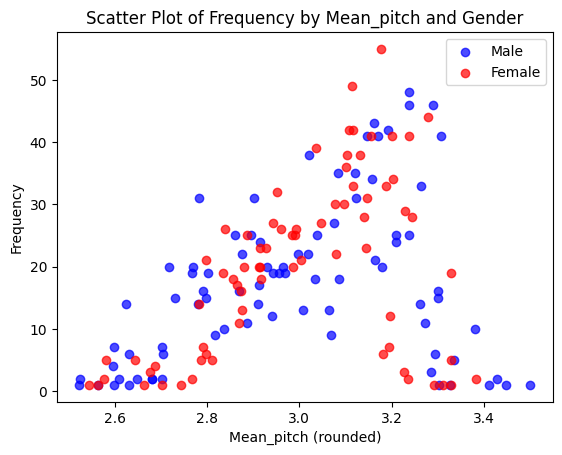

In [616]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import math

precision = {
    'mean_pitch':2, 
    'max_pitch':3, 
    'min_pitch':3, 
    'jitter':2, 
    'shimmer':2, 
    'energy':1, 
    'zcr_mean':2, 
    'spectral_centroid_mean':2,
    'tempo':3,
    'hnr':0
}

# TODO: add a second log10, one for skewness and one for order of magnitude
def round_column(data: pd.DataFrame, col: str):
    if col != 'hnr':
        display(math.log10(data[col].iloc[0]))
        mean_value = data[col].mean()
        display(math.floor(math.log10(mean_value)))
        display(int(math.floor(math.log10((mean_value)))))
        rounded_col = np.round(
            np.log10(data[col]), 
            int(math.floor(math.log10((mean_value))))-1
        )
    else:
        rounded_col = np.round(data[col], precision[col])
    return rounded_col


def plot_distribution(X_df: pd.DataFrame, col: str):    
    temp = X_df[['gender', col]].copy()

    male_temp = temp[temp['gender'] == mapper['male']].copy()
    female_temp = temp[temp['gender'] == mapper['female']].copy()

    male_temp[col] = round_column(male_temp, col)
    female_temp[col] = round_column(female_temp, col)
    # if col != 'hnr':
    #     male_temp[col] = np.round(
    #         np.log10(male_temp[col]), 
    #         int(
    #             math.floor(
    #                 math.log10(
    #                     abs(X_df.iloc[:, 1].mean())
    #                 )
    #             )
    #         )-1
    #     )
    #     female_temp[col] = np.round(
    #         np.log10(female_temp[col]), 
    #         int(
    #             math.floor(
    #                 math.log10(
    #                     abs(X_df.iloc[:, 1].mean())
    #                 )
    #             )
    #         )-1
    #     )
    #     # female_temp[col] = np.round(np.log10(female_temp[col]), precision[col])
    # else:
    #     male_temp[col] = np.round(male_temp[col], precision[col])
    #     female_temp[col] = np.round(female_temp[col], precision[col])

    male_temp['frequency'] = male_temp[col].map(male_temp[col].value_counts())
    female_temp['frequency'] = female_temp[col].map(female_temp[col].value_counts())

    male_temp = male_temp.drop_duplicates()
    female_temp = female_temp.drop_duplicates()

    male_temp = male_temp.sort_values(by='frequency', ascending=False)
    # Separate males and females
    display(male_temp)
    # Plot males
    plt.figure()
    plt.scatter(male_temp[col] + np.random.uniform(-0.1, 0.1, size=len(male_temp)), 
                male_temp['frequency'], 
                color='blue', alpha=0.7, label='Male')
    
    # Plot females
    plt.scatter(female_temp[col]+ np.random.uniform(-0.1, 0.1, size=len(female_temp)), 
                female_temp['frequency'], 
                color='red', alpha=0.7, label='Female')
    
    plt.xlabel(f'{col.capitalize()} (rounded)')
    plt.ylabel('Frequency')
    plt.title(f'Scatter Plot of Frequency by {col.capitalize()} and Gender')
    plt.legend()
    plt.show()

# Example usage
i = 0
col = list(precision.keys())[i]
display(col)
plot_distribution(step3_dev_df, col)


## First regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

forest = RandomForestRegressor()

# display(working_df)
# display(ages_df)

X_train, X_val, y_train, y_val = train_test_split(step3_dev_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

forest = forest.fit(X_train.values, y_train.values.reshape((-1,)))
y_pred = forest.predict(X_val.values)

display(root_mean_squared_error(y_val.values, y_pred))

#10.402057038409454

In [ ]:
y_eval_pred = forest.predict(step3_eval_df.values)

from collections import Counter

display(np.max(y_eval_pred), np.min(y_eval_pred))
display(np.max(ages_df), np.min(ages_df))

In [ ]:
y_eval_pred

In [17]:
with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")

    for id, y in enumerate(y_eval_pred):
        fout.write(f"{id}, {y}\n")

In [ ]:
from sklearn.model_selection import cross_val_score

abs(cross_val_score(RandomForestRegressor(n_jobs=-1), step3_dev_df, ages_df, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1).mean())